---

<h1>Classification - Recurrent Neural Network - Twitter Sentiment</h1>
<p>
The Dataset I have chosen is the Twitter Sentiment Analysis dataset, taken from Sentiment140
    <ul>
        <li>This Dataset essentially contains multiple columns</li>
        <li>The polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)</li>
        <li>The id of the tweet</li>
        <li>The date of the tweet </li>
        <li>The query. If there is no query, then this value is NO_QUERY</li>
        <li>The user that tweeted</li>
        <li>The text of the tweet</li>
    </ul>
<a href='http://help.sentiment140.com/for-students'>http://help.sentiment140.com/for-students</a>
</p>

---

## Table of Contents:
* [What / Why a Reccurent Neural Network](#what-why-rnn)
* [Task Overview](#overview)
* [Imports](#imports)
* [Exploratory Data Analysis + Cleaning](#EDA)
* [Preprocess + Splitting the data](#pre)
* [Training + Compiling the RNN model](#rnn)
* [Model Evaluation](#evaluation)

---

## What / Why a Recurrent Neural Network <a class="anchor" id="what-why-rnn"></a>
<p>
Recurrent Neural Networks (RNN) is more powerful / robust type of neural network. Like many other neural networks, it's conception began in the 1980's, however recent years has seen this neural network gain more popularity in the data science enviroment. What really makes RNN more special than it's other counter parts is it's use of Long Short-Term Memory (LSTM).
<br><br>
LSTM operate by learning in order dependence where the output of a previous step is used as an input in the current step. Because of this, RNN can remember important things about the input they received, which allows the neural network to be very precise in its prediction. This is what ultimately makes RNN the prefered choice for sequential data like time series, financial data, audio, video, weather and in the case of this notebook text / speech.
<br><br>
For the data set chosen for this notebook I will be using the text data of user's tweet to determine their sentiment within the tweet. This, I will be processing a massive NLP dataset of large amounts of raw text. This means I will be peforming deep learning, so a neural netowrk will be the model and since my main feature will be the text data of the tweet, a Reccurent Neural Network will be the excat choice of the neural network needed.
</p>

---

## Task Overview <a class="anchor" id="overview"></a>
<p>
For this notebook the main mission will be to construct a RNN model will process the data and peform a binary classification to determine whether the twitter posts reflect a positive or negative sentiment.
<br>
The process will be as follow:
    <ol>
        <li>Import the necessary packages</li>
        <li>Load the dataset using spark</li>
        <li>Read the dataset and pefrom any necessary cleaning needed</li>
        <li>Once cleaning is complete, analyze the dataset, learning any insight about the tweet's sentiment</li>
        <li>Split the data and preform the preprocessing of the text data (stemming, tokenization, embedding, etc...)</li>
        <li>Build the RNN model's layer including the LSTM layer</li>
        <li>Run the model</li>
        <li>Analyze / Evaluate the model outputs (model accuracy and model loss)</li>
    </ol>
</p>

---

## Imports <a id="imports"></a>

In [1]:
# Numpy will assist with any arithemtics formulas or wrangling for the data test(from new repo loc)
# pyspark will assist in structuring our data, reading and presenting our outputs
import numpy as np
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

In [2]:
# Next, I imported the libraries I will be using for my data visualization
# Matplotlib is also used for graph visualization (I will mostly be using it for outputing the graphs)
# Seaborn is a robust library that will assist in analyzing the data and presenting (I will be using it for my intial data analysis)
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# For my textdata I will be using the nltk libraries for my text data cleaning
# I will be using the SnowballStemmer for my Lemmatization
# SnowballStemmer is a rectified version of Porter’s stemmer algorithm.
# I will use the corpus stopwords library to clean out all the common stop words in the text data.
# re is will be my method to use a regex pattern to remove the special characters from the tweets
# Finally wordcloud will be used to give a visual representations of words that give greater prominence to words that appear more frequently in the tweets.
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from wordcloud import WordCloud

In [56]:
# Using the sklearn.model_selection method to import the train_test_split
# LabelEncoder will be used to encode the y values so they can be processed in the model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
#Tokenizer will be used to split the tweet's text into a list of tokens to be vectorized.
from keras.preprocessing.text import Tokenizer
#Since I will using LSTM for the model, I will need to pass inputs of the same size for the sequence
#pad_sequencce will perform that for me
from keras.preprocessing.sequence import pad_sequences

In [6]:
# Since I will be performing a Binary Classifcation models 
# I will need the following metrics to evaluate it's performance
# classification_report will display the a report with it's Precision and Recall score (will explain those concepts deeper into the Notebook) 
# confusion_matrix will display the matrix of the model performed with it's predictions, this will be done by displaying it's True Negative, True Positive, False Negative and False Positive predicitons
# accuracy_score will display the overall accuracy of the current model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [7]:
from IPython.display import display, HTML
import itertools

In [8]:
#Tensorflow and Keras will be used for the construction of the RNN model's layers
import tensorflow as tf
from keras import models
from keras import layers

# Import various layers needed for the architecture from keras
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [9]:
from sklearn.metrics import classification_report

---

## Exploratory Data Analysis + Cleaning <a class="anchor" id="EDA"></a>

In [10]:
#Spark session is built and created using my local system
#This variable will be used for the spark data analysis
spark = SparkSession.builder.master('local').appName('TwitterSentimentAnalysis').config('spark.executer.memory', '6gb').getOrCreate()

In [11]:
#url variable is used to store the path to the csv file of the dataset
#dataframe variable is then created using the spark read format method
url = 'C:/Users/Dylan/Desktop/Datasets/trainingandtestdata/training.1600000.processed.noemoticon.csv'
df = spark.read.format('com.databricks.spark.csv').options(header='False').load(url).toDF('sentiment','id','date','query_string','user','text')

<p>
Since the dataset was raw to the point of having no headers at all.
<br>
The .toDF() method was used to apply appropiate headings to the columns
    <ul>
        <li>sentiment</li>
        <li>id</li>
        <li>date</li>
        <li>query_string</li>
        <li>user</li>
        <li>text</li>
</p>

In [12]:
df.show()

+---------+----------+--------------------+------------+---------------+--------------------+
|sentiment|        id|                date|query_string|           user|                text|
+---------+----------+--------------------+------------+---------------+--------------------+
|        0|1467810369|Mon Apr 06 22:19:...|    NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|        0|1467810672|Mon Apr 06 22:19:...|    NO_QUERY|  scotthamilton|is upset that he ...|
|        0|1467810917|Mon Apr 06 22:19:...|    NO_QUERY|       mattycus|@Kenichan I dived...|
|        0|1467811184|Mon Apr 06 22:19:...|    NO_QUERY|        ElleCTF|my whole body fee...|
|        0|1467811193|Mon Apr 06 22:19:...|    NO_QUERY|         Karoli|@nationwideclass ...|
|        0|1467811372|Mon Apr 06 22:20:...|    NO_QUERY|       joy_wolf|@Kwesidei not the...|
|        0|1467811592|Mon Apr 06 22:20:...|    NO_QUERY|        mybirch|         Need a hug |
|        0|1467811594|Mon Apr 06 22:20:...|    NO_QUERY|    

<p>
Then completed the cell by using the head() function to read and analyze the data
<br><br>
Now that I can the relevant titles for the columns, it will be best to do some exploring of the data, to see if there is anything useful to identify.
<br><br>
Correct cleaning can be applied as well through the process
</p>

In [13]:
pandasDF = df.toPandas()
pandasDF.shape

(1600000, 6)

<p>
The .toPandas() is applied to make use of Pandas syntax for the data analysis, while spark is being used.
<br><br>
Checking the shape, I can confirm that there are 1600000 rows of data, supported by 6 columns. The six columns I created earlier.
</p>

In [14]:
pandasDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   sentiment     1600000 non-null  object
 1   id            1600000 non-null  object
 2   date          1600000 non-null  object
 3   query_string  1600000 non-null  object
 4   user          1600000 non-null  object
 5   text          1600000 non-null  object
dtypes: object(6)
memory usage: 73.2+ MB


<p>
.info() is then used to gain better view of the 6 columns what data type they represent.
<br><br>
In this case, they all are object types
</p>

sentiment       0
id              0
date            0
query_string    0
user            0
text            0
dtype: int64

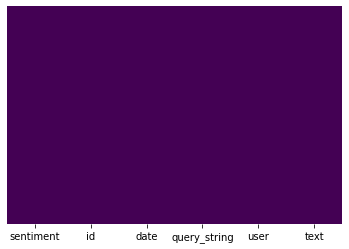

In [15]:
sns.heatmap(pandasDF.isnull(), yticklabels=False, cbar=False, cmap='viridis')
pandasDF.isnull().sum()

<p>
A visual way of checking is to the use the heatmap() function from Seaborn. I then add the dataframe setting it to display only isnull() values. Then I set the cmap to 'viridis' for my visual benefit. The purple image will indicate values being detected. Any yellow tints will indicate any null values being detected.
<br><br>
The sum() is also applied to numerically tell me if there are any null values.
</p>

In [16]:
pandasDF['sentiment'].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

<p>
Next I used .value_counts() on the sentiment column to see the diversity between the sentiments.
<br><br>
Suprisingly I found that there is a balance split between negative and positive sentiments, no neturals at all. This bascially confirms to me that balancing is sorted, plus a binary classifcation can be applied. 
</p>

In [17]:
pandasDF.drop(['id','date','query_string','user'],axis=1,inplace=True)
pandasDF.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


<p>
Next step is to used the .drop() method to drop all the uneeded columns, for this model, I only need two columns.
<br><br>
Sentiment - Acting as the target value.
<br><br>
text - The actual text data from the tweet.
</p>

In [18]:
lab_to_sentiment = {'0':'Negative', '4':'Positive'}
def label_decoder(label):
  return lab_to_sentiment[label]
pandasDF['sentiment'] = pandasDF['sentiment'].apply(lambda x: label_decoder(x))
pandasDF.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


<p>
Now just to make the analyzing easier, I added a more meaningful label for the sentiments.
<br><br>
0 will now say Negative and 4 will now say Positive.
</p>

In [19]:
pandasDF[pandasDF['sentiment'] == 'Negative'].head(10)

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."
5,Negative,@Kwesidei not the whole crew
6,Negative,Need a hug
7,Negative,@LOLTrish hey long time no see! Yes.. Rains a...
8,Negative,@Tatiana_K nope they didn't have it
9,Negative,@twittera que me muera ?


<p>
Next wanted to see the first ten Negative tweets
<br><br>
They seem to be sports related
</p>

In [20]:
pandasDF[pandasDF['sentiment'] == 'Positive'].head(10)

,sentiment,text
800000,Positive,I LOVE @Health4UandPets u guys r the best!!
800001,Positive,im meeting up with one of my besties tonight! ...
800002,Positive,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,Positive,Being sick can be really cheap when it hurts t...
800004,Positive,@LovesBrooklyn2 he has that effect on everyone
800005,Positive,@ProductOfFear You can tell him that I just bu...
800006,Positive,@r_keith_hill Thans for your response. Ihad al...
800007,Positive,"@KeepinUpWKris I am so jealous, hope you had a..."
800008,Positive,"@tommcfly ah, congrats mr fletcher for finally..."
800009,Positive,@e4VoIP I RESPONDED Stupid cat is helping me ...


<p>
Pulling first ten positive tweets
<br><br>
More of a mix bag of congratulations, to people talking about meeting up
</p>

In [21]:
pandasDF.describe()

,sentiment,text
count,1600000,1600000
unique,2,1581466
top,Negative,isPlayer Has Died! Sorry
freq,800000,210


In [22]:
pandasDF.groupby('sentiment').describe()

text                                        
            count  unique                        top freq
sentiment                                                
Negative   800000  790185  isPlayer Has Died! Sorry   210
Positive   800000  793506              good morning   118

<p>
Used describe() method to pull numerical milestones of the data
<br><br>
Grouping the data by the sentiment, I can see the common tweets being either:
<br><br>
Negative - people expressing 'isPlayer has died'. charming
<br><br>
Positive - people saying 'good morning'.
</p>

In [23]:
pandasDF['length'] = pandasDF['text'].apply(len)
pandasDF.head()

,sentiment,text,length
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,Negative,is upset that he can't update his Facebook by ...,111
2,Negative,@Kenichan I dived many times for the ball. Man...,89
3,Negative,my whole body feels itchy and like its on fire,47
4,Negative,"@nationwideclass no, it's not behaving at all....",111


<p>
Next for analysis I need to understand the overall length of these tweets.
<br><br>
So I created another column named length that will have the character length of the tweets
</p>

<AxesSubplot:xlabel='length', ylabel='Count'>

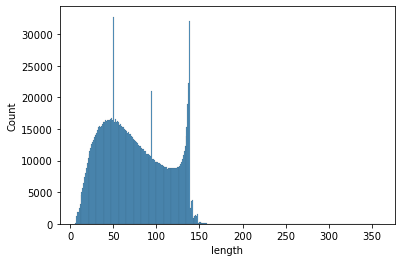

In [24]:
sns.histplot(pandasDF['length'])

<p>
Using a seaborn histplot we can see the length size of the tweets.
<br><br>
Majority seem to mid around the 50 and 140 mark, with 80 coming in at a close second
<br><br>
Maddingly enough the character mark goes past well past 300000 mark 
</p>

In [25]:
pandasDF['length'].describe()

count    1.600000e+06
mean     7.404176e+01
std      3.638799e+01
min      6.000000e+00
25%      4.400000e+01
50%      6.900000e+01
75%      1.040000e+02
max      3.590000e+02
Name: length, dtype: float64

<p>
Using a describe of the length column, this pretty much confirms my analysis
<br><br>
The largest even piercing the 3.590000e+02 characters
</p>

In [26]:
pandasDF[pandasDF['length'] == 3.590000e+02]['text'].iloc[0]

'5 days till new top gear  �?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?��?�'

<p>
Out of sheer curiosity, I needed to see what that maddingly long tweet could be.
<br><br>
It ended up being a tweet with at best 5 actually words, before being spammed with emojis
<br><br>
excitment for the new top gear??
<br><br>
My guess this is a bot, used to drive traffic engagement for top gear or maybe just a troll who made a bot. 
</p>

array([<AxesSubplot:title={'center':'Negative'}>,
       <AxesSubplot:title={'center':'Positive'}>], dtype=object)

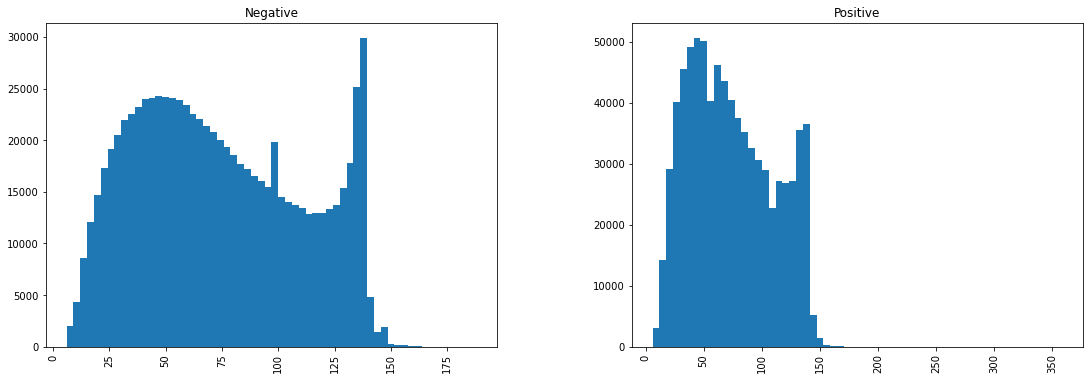

In [27]:
pandasDF.hist(column='length', by='sentiment', bins=60, figsize=(18,6))

<p>
Next I created a comparision hist diagram to analyze the Negative and Positive tweets.
<br><br>
For negative we can see the graph can take on a wave effect. Whether it's to the point or an entire novel, people can find a way to be mean.
Believable, some twitter rants go on like dissertations.
<br><br>
For Positive, the tweets live on the much shorter side.
<br><br>
Makes sense. Most tweets on the positive side tend to be people experessing something they enjoyed at the moment giving a quick update or replying to something they found amusing.
</p>

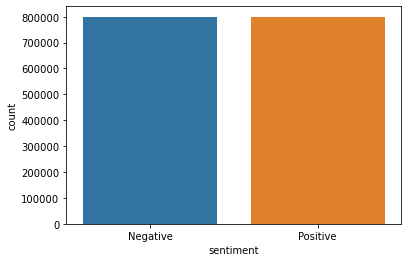

In [28]:
X_axis = ['sentiment']
for col in X_axis:
    sns.countplot(data=pandasDF, x=col)
    plt.show()

<p>
Check which sentiment is the dominante one in the dataset. This confirms to me, that the dataset is balanced.
<p>

(0.0, 260.0)

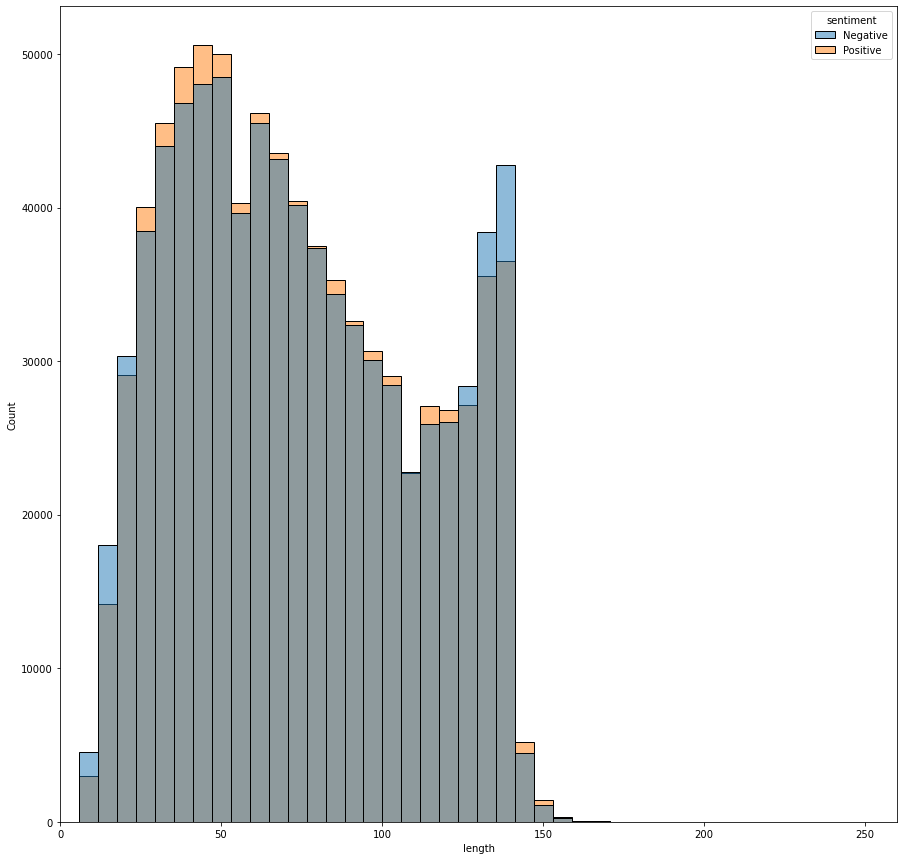

In [29]:
fig, ax = plt.subplots(figsize=(15,15))
sns.histplot(
    data=pandasDF, x='length', hue=pandasDF['sentiment'],
    bins=60, ax=ax
)
ax.set_xlim([0, 260])

<p>
Finally a histplot to view the total count of tweet lengths
<br><br>
Majority of Negative live in the 140 char mark
<br><br>
Majority of Positive live in the 40 char mark
<br><br>
Basically means people have a lot to say when they are upset.
</p>

---

## PreProcess + Splitting the data <a class="anchor" id="pre"></a>

<p>
Next step is to apply pre-processing to the text data of the tweets.
<br><br>
For this notebook I will remove any stop words located in the tweets, preform stemming and use a regex pattern to remove any special characters contained within the tweets.
</p>

In [30]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

<p>
First thing to do is to clean out the most common stopwords from the messages
<br><br>
To do this I will call the nltk stopwords library and use those list of words to clean out the messages
<br><br>
Stop words are generally the most common words in text data and because of that overall don't offer any uniqueness for the text data
</p>

In [31]:
stemmer = SnowballStemmer('english')

<p>
This variable will act for the stemming process
<br><br>
Stemming will reducing words into their root forms
<br><br>
For this notebook, I will be making use of the SnowballStemmer package
<br><br>
Snowball stemmer is a stemming algorithm (also known as Porter2), basically it is Porter stemmer, but it is considered to be a better version since it is more aggresive in it's process of reducing words to their stems
<br><br>
Since I will be stemming tweets that contain very casual text which special characters, snowball will be better sutied.
</p>

In [32]:
text_cleaning_regex = '@S+|https?:S+|http?:S|[^A-Za-z0-9]+'

This variable will contain the regex pattern that will be used to filter out the special characters from the tweets

In [33]:
# For the text data cleaning process I have prepared a definition to basically clean the data in one big swoop
# Cleaning
# 1.Use regex pattern to clean the special characters out
# 2. Use tokens list to loop each word
# 3. Check is token word a stop word, if not passed it along the list
# 4. Pefrom Snowball stemmer on the current toke of the list
# 5. Appened the now fully cleaned token to the list to be returned

def clean_tweets(text, stem=False):
  # Text passed to the regex pattern
  text = re.sub(text_cleaning_regex, ' ', str(text).lower()).strip()
  # Empty list created to store final tokens
  tokens = []
  for token in text.split():
    # check if the token is a stop word or not
    if token not in stop_words:
      if stem:
        # Passed to the snowball stemmer
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [34]:
#Dropping the lenght column, I wont need it for the model
pandasDF.drop(['length'],axis=1,inplace=True)
#Apply the clean tweets definition to the tweets
pandasDF['text'] = pandasDF['text'].apply(lambda x: clean_tweets(x))

In [35]:
pandasDF.head()

,sentiment,text
0,Negative,switchfoot http twitpic com 2y1zl awww bummer ...
1,Negative,upset update facebook texting might cry result...
2,Negative,kenichan dived many times ball managed save 50...
3,Negative,whole body feels itchy like fire
4,Negative,nationwideclass behaving mad see


<p>
With the cleaning process completed, I then pull the head of the dataframe to analyze the data in it's current state
<br><br>
I can the length column has been dropped and more importantly the text column has been properly cleaned from stop words, special characters and the words have been properly stemmed.
</p>

<p>
With cleaning completed, lets created a word cloud to visually see what words at their most base from, play role in positive and negative sentiments.
<br><br>
Word clouds are basically a collection or cluster of words that play a role in the dataframe, their importance depicted by their different sizes.
</p>

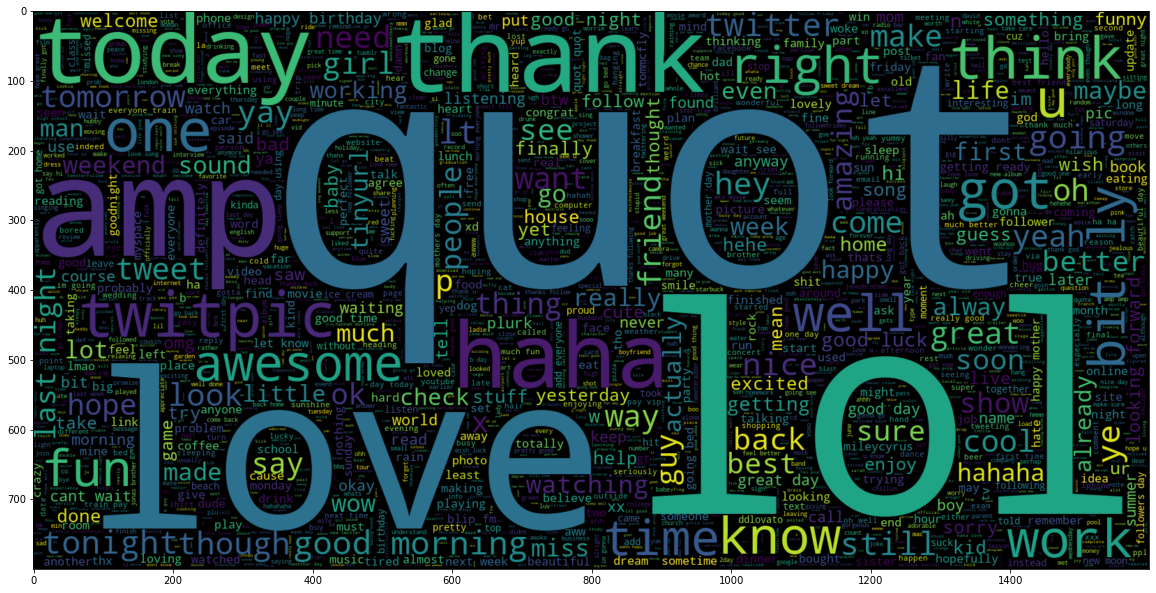

In [36]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(pandasDF[pandasDF['sentiment'] == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

<p>
The above word cloud is for words associated with a Postivie sentiment
<br><br>
We can see the biggest words being 'love','lol' and 'good morning'
</p>

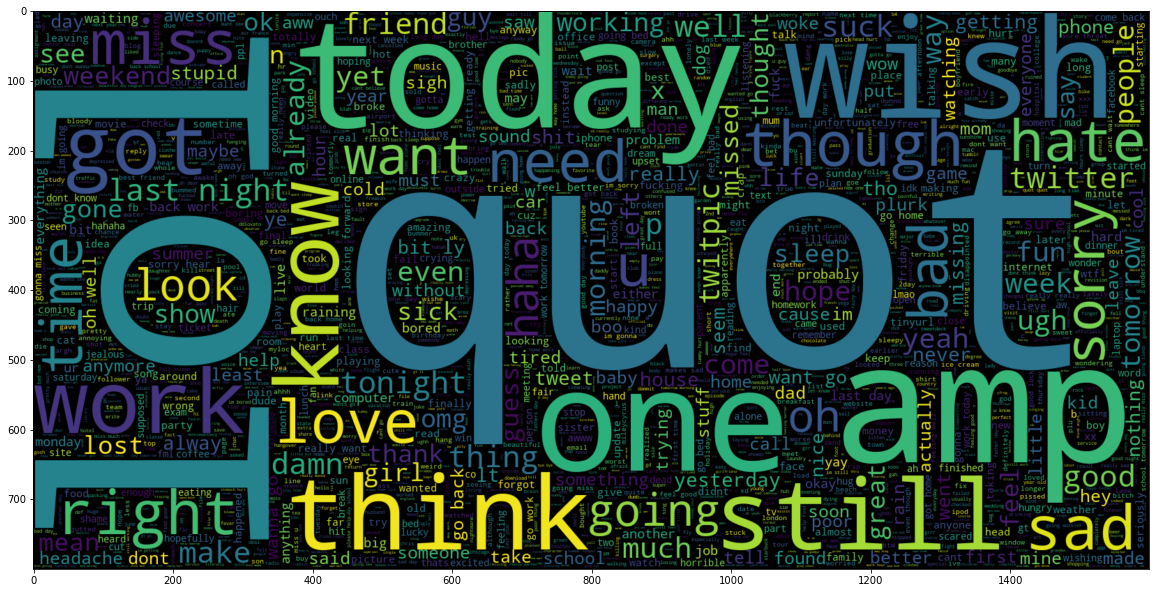

In [37]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(pandasDF[pandasDF['sentiment'] == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

<p>
The above word cloud is for words associated with a Negative sentiment
<br><br>
We can see the biggest words being 'sad','still', 'sad' and interesntly enough, again 'lol'
</p>

<p>
More importantly, with cleaning now done, I can now start splitting the data so it can be tokenized
</p>

In [38]:
#Splitting the data
train_data, test_data = train_test_split(pandasDF, test_size=0.2)
print('Train Data size:',len(train_data))
print('Test Data size:',len(test_data))

Train Data size: 1280000
Test Data size: 320000


<p>
For the splitting, I am using the train_test_split() method of sklearn library to split the data with a 20% set to test.
<br><br>
When it come to NLP, espcially speech text and tweets, a larger training set will be useful to attained a better model.
</p>

In [39]:
train_data.head(10)

,sentiment,text
1159553,Positive,dbarnett congratualtions anniversary
102079,Negative,debra sounds creepy remembers last year neighb...
100198,Negative,mubblegum sweet play jedi alliance mean let
1369472,Positive,isaacdoom join club importantly new kit
114638,Negative,come home early blasted rain
119722,Negative,work much spanish hw get home miscellaneous ma...
1301435,Positive,love whole sleeping till 12 30 thing latley go...
853454,Positive,martha stewart jay leno way says twitter sound...
445519,Negative,bens home missed smallville
211937,Negative,suns gone away chloee mwaha lol yehh im offica...


<p>Taking a quick look of the first 10 entries of the training data</p>

<p>
Now I will apply Tokenization 
<br>
Tokenization is the process of taking a sequence of words and chopping each individual word up into it's peice refered to as a token. This will allow each peice to be indexed and vectorized. Which will be needed for the run the model.
</p>

In [40]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 565579


<p>
For the code above I have used the Keras package called Tokenizer() then the fit_on_text() method to fit the training data tweets, to tokenize the current sentences.
<br>
Also added a dictionary where each word will be mapped
<br>
Finally added a vocab_szie to show the total number of words in the current data corpus
</p>

In [41]:
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),maxlen=30)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),maxlen=30)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


<p>
Next, since I am building a RNN model, the data needs to be in sequence, meaning I need to pass inputs of the same size.
<br>
To do this, I am using the pad_sequences() method, which basically returns sequences of the same size, specificed by the user.
<br>
In my case, I set the max length to 30
</p>

In [42]:
labels = train_data.sentiment.unique().tolist()

In [43]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


<p>
For this step, since I am peforming binary classification between the targets of 'Negative' and 'Positive'. I now need to apply encoding to transform the values to 0 and 1's.
<br>
This way the model will be able to digest and understands the weights behind the target values.
<br>
0 = Negative
<br>
1 = Positive
<br>
This is accomplished using the LabelEncoder method, which will apply the encoding for me. From there is was a matter of just supplying the encoder with e y_train and y_test values.
</p>

In [44]:
embeddings_index = {}
# opening using the pathway to the glove algorithm file
f = open('C:/Users/Dylan/Desktop/Datasets/glove.6B/glove.6B.300d.txt', encoding="utf8")
for line in f:
    # For each line file, the words are split and stored in a list
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


<p>
For this I've applied a word embedding model. Word Embedding is needed because to capture the context behind words in it's current point in the tweet to truly understand the sentiment behind it.
<br>
English is a tricky language, and words can be applied in both a positive and negative sentiment, it all comes down to context. This is where word embedding comes into resuce, word embedding is capable of capturing the context of words in a document, determine the sematic and snytatic similairty and relations.
<br>
And since I am building a RNN model for sentiments determination. Having a model that understands the contexts of the words will prove usesful for the accuracy.
</p>

<p>
Luckily... There are plenty of already made word embedding models that can be used for this occasion.
<br>
The I am using is pre-trained model called 'GloVe'
</p>

In [45]:
# Creating an matrix with zeroes of shape vocab x embedding dimension
embedding_matrix = np.zeros((vocab_size, 300))
# Iterate through word, index in the dictionary
for word, i in word_index.items():
    # extract the corresponding vector for the vocab indice of same word
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Storing it in a matrix
        embedding_matrix[i] = embedding_vector

<p>
Using the word index created in the previous cell, each words goes through the for loop to map with the embedding matrix index
</p>

In [46]:
embedding_layer = layers.Embedding(vocab_size,300,weights=[embedding_matrix],
                                          input_length=30,trainable=False)

<p>Then create an embedding layer with those indexes now mapped, which will be used for the RNN model</p>

---

## Training + Compiling the RNN model <a class="anchor" id="rnn"></a>

<p>Now for the main event, training and compiling the RNN model</p>

In [47]:
#The sequence layer being an input need to build a RNN
sequence_input = Input(shape=(30,), dtype='int32')
#The embedding layer made in the previous cell
embedding_sequences = embedding_layer(sequence_input)
#The layers of the RNN with LSTM included
#All captured in an x variable to feed to the out layer
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
#Output layer having the activation function of sigmoid since I am preforming binary classification
outputs = Dense(1, activation='sigmoid')(x)
#Capturing the complete model
model = tf.keras.Model(sequence_input, outputs)

<p>
Reccurent Neural Networks operate by using secuqnces of data, with the first one needing to be the input layer
<br><br>
    <ol>
        <li>Input Layer - This layer take in the data sequences which how the RNN needs to take in it's data</li>
        <li>Embedding Layer - This Layer will generate the embedding vector for each input sequence</li>
        <li>Conv1D Layer - This layer will concolve the data into smaller feature vectors</li>
        <li>Bidirectional + LSTM layer - This layer will have a bidrectional reccurent layer that will connect two hidden layers of opposite direction so the neural network will get it's informatiom moving both backwards and forwards. From withn there the model will initate the main man of the model. The LSTM layer. This will use the memory state to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.</li>
        <li>Dense Layer - This layer is deeply connected with its preceding layer which means the neurons of the layer are connected to every neuron of its preceding layer.</li>
        <li>Dropout Layer - This layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting</li>
        <li>Another Dense Layer - To make up for the previous dropout</li>
        <li>Output Layer - The final layer that will take the final out, and more importantly will use an activiation function of sigmoid which will be needed because I am peforming a Binary classification</li>
    </ol>
</p>

In [48]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           169673700 
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048 

<p>Checking a summary of the model before compiling</p>

In [49]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy',metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,min_lr = 0.01, monitor = 'val_loss',verbose = 1)

<p>
Now before I start compiling the model, I will also set up callback layers that will be called at the end of each epoch.
This will be useful to handle any over-fitting or under-fitting along with the dropout layer.
    <ol>
        <li>LRScheduler - Changes a Learning Rate at specfic epoch to achieve more improved result</li>
        <li>ModelCheckPoint - Saves best model while training based on the current metrics at the moment</li>
    </ol>
</p>

In [50]:
history = model.fit(X_train, y_train, batch_size=1024, epochs=10,
                    validation_data=(X_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 576s 458ms/step - loss: 0.5194 - accuracy: 0.7392 - val_loss: 0.4821 - val_accuracy: 0.7663 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 566s 453ms/step - loss: 0.4877 - accuracy: 0.7621 - val_loss: 0.4709 - val_accuracy: 0.7729 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 572s 457ms/step - loss: 0.4775 - accuracy: 0.7690 - val_loss: 0.4675 - val_accuracy: 0.7758 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 575s 460ms/step - loss: 0.4711 - accuracy: 0.7728 - val_loss: 0.4639 - val_accuracy: 0.7780 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 587s 469ms/step - loss: 0.4665 - accuracy: 0.7759 - val_loss: 0.4622 - val_accuracy: 0.7782 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 589s 471ms/step - loss: 0.4632 - accuracy: 0.7780 - val_loss: 0.4610 - val_accuracy: 0.7803 - lr: 0.0010
Epoch 7/10
1250/1250 [============

<p>
Finally training the model...This took a total of 2 hours on my specs :')
</p>

---

## Model Evaluation <a class="anchor" id="evaluation"></a>

<p>
With the the model trained and compiled, now to evaluate it
</p>

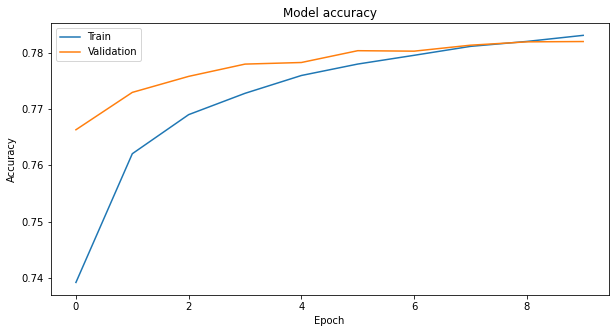

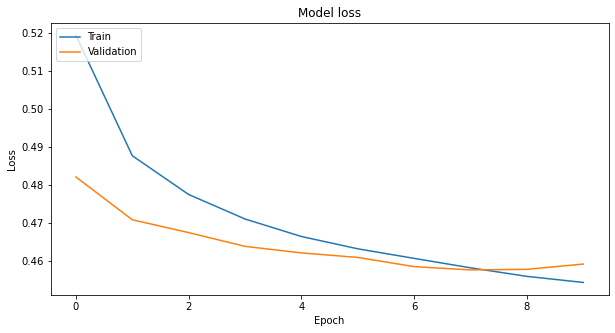

In [67]:
# Model Accuracy
fig, axl = plt.subplots(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

 # Model Loss
fig, axl = plt.subplots(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.show()

<p>
Evaluating the Learning curve accuracy and Loss, I can see:
    <ul>
        <li>Model Accuracy - I can as the epochs progress, the accuracy goes up, which is what I want. This collide at 5 epochs, which might add towards to overfitting, but the dropout layer and the rollback layers clearly helps mends that in the process. At best the accuracy can be 78 to 77 percent near it's end, before overfitting. Which is good for a twiiter analysis of text data </li>
        <li>Model Loss - I can the model loss decreases as each epoch, this is good, showing the model is handling the data well per iteration, interestingly enough their is spike in validation at around epoch 5. but the Loss still continues which is good.</li>
    </ul>
</p>

In [65]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"

scores = model.predict(X_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 34s 1s/step


<p>
Next part of my evaluation I will like to make a Confusion Matrix since I am evaluating a Binary Classification model.
<br><br>
Before that I created a custom definition to determine the excat values of the text values and return whether it was Positive or Negative sentiment (previously I encoded them for the model), and create the vectors into a 1 dimenionsal variable so I can feed it to the confusion matrix
<br><br>
Those values are then returned to be the predictions variable
</p>

In [53]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

<p>
Custom definiton for the confusion matrix, as well as to style it to present the excat accuracy percentage.
</p>

In [70]:
def ROC_Curve_Graph(y_test):
    fpr, tpr, _ = roc_curve(y_test,  scores)
    auc = roc_auc_score(y_test, scores)
    plt.subplots(figsize=(10,5))
    plt.plot(fpr,tpr,label="Prediction, auc="+str(auc))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.legend(loc=4)
    plt.show()

<p>
Custom definiton for the ROC Chart, shows the curve of the true and flase positive rates for different values between 0 and 1. A perfect classifier would have a curve that goes straight up the left side and straight across the top. The diagonal line across the char represents the probability of predicting correctly with a 50/50 random prediciton. Therefore I want the curve to be higher and more distant from the diagonal line. Because it basically confirms that the model is certainly positive of it's predictions with no guessing.
</p>
<p>
Another point the graph will be doing is calculating the AUC. The Area Under the Curve (AUC) is a value between 0 and 1 that quantifies the overall performance of the model.
</p>

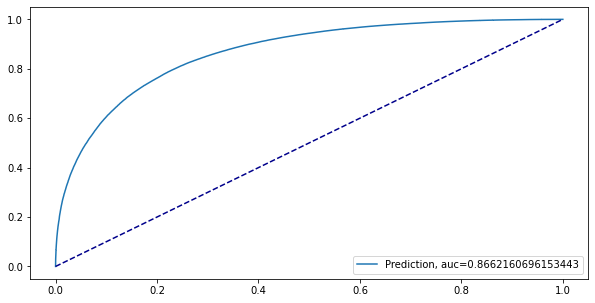

In [71]:
ROC_Curve_Graph(y_test)

<p>
A perfect classifier would have a curve that goes straight up the left side and straight across the top. The diagonal line across the char represents the probability of predicting correctly with a 50/50 random prediciton. Therefore I want the curve to be higher and more distant from the diagonal line. Because it basically confirms that the model is certainly positive of it's predictions with no guessing.
</p>
<p>
For this graph AUC = 0.86. Very close to 1, so for all intents and purposes I can conclude that this model performs quite well
</p>

----------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.80      0.75      0.77    160092
    Positive       0.76      0.81      0.79    159908

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

----------------------------------------------------------------


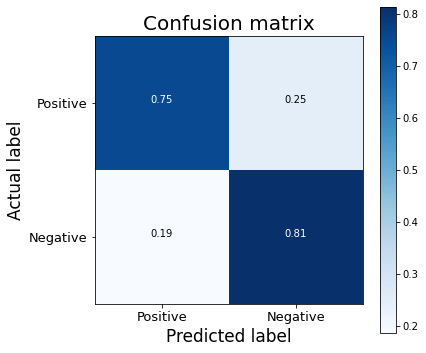

In [62]:
display(HTML("<h1>RNN Model</h1>"))
# Getting and printing model scores
print('----------------------------------------------------------------')
print(classification_report(list(test_data.sentiment), y_pred_1d))
print('----------------------------------------------------------------')
# Look at classification report to evaluate the model
# Using graph definitions made earlier
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

<p>
Looking at the classification report and confusion matrix, the information is as follows:
<br><br>
<h3>Classification Report Recap</h3>
    <ul>
        <li>val_accuracy: 78%</li>
        <li>val_loss: 0.45</li>
        <br>
        <li>accuracy: 78%</li>
        <li>loss: 0.45</li>
        <br>
        <li>Precision[Negative]: 80%</li>
        <li>Precision[Positive]: 76%</li>
        <br>
        <li>Recall[Negative]: 75%</li>
        <li>Recall[Positive]: 81%</li>
         <br>
        <li>f1-score[Negative]: 77%</li>
        <li>f1-score[Positive]: 79%</li>
    </ul>
    All values are closely correlated with another, which is a good sign of no over/under fitting, and with a high Precision and Recall, I know a good portion of the dataset is being taken into consideration.
<h3>Confusion Matrix Recap</h3>
    A confusion matrix shows the total number of cases where:
    <ul>
        <li>The model predicted Positive and the actual label is Positive (true positives; top left)</li>
        <li>The model predicted Negative and the actual label is Negative (true negatives; bottom right)</li>
        <li>The model predicted Negative and the actual label is Positive (false negatives; top right)</li>
        <li>The model predicted Postive and the actual label is Negative (false positives; bottom left)</li>
    </ul>
    For the case of the graph, I also have legend indicating the value amounts. So for the case of the analysis if the false predictions are above the second element (that being 0.3, starting from the bottom). Then the accuracy cannot be trusted. However for the case of this graph, the false predictions are below the first element (that being 0.2, starting from the bottom).
    <br><br>
    Both True Positive and False Positive were the highest point in the Confusion Matrix Graph.
    <br>
    AUC = 0.86
    <br>
    This tells the the model is as accurate as it can be for RNN
</p>